In [1]:
import certifi
import ssl
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import sys
import os
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from torch.onnx.symbolic_opset9 import tensor

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}

In [2]:
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), "scripts") )

root_path = os.path.dirname(os.getcwd())

#forecast with Moirai

total length: 4581
Index(['bitcoin_price'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

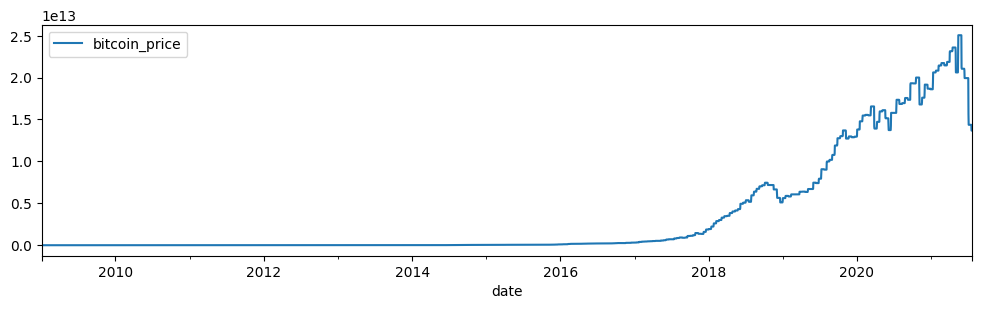

In [27]:
# First: Load dataframe

df = pd.read_csv(os.path.join(root_path, "data", "bitcoin_values.csv"), parse_dates=True)

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

In [35]:
# create the train and test sets
train_window = 12 * 365 # days
prediction_window = 30  # days

inp = {
    "target": df["bitcoin_price"].to_numpy()[:train_window],  # 11 years
    "start": df.index[0].to_period(freq="H"),
}
label = {
    "target": df["bitcoin_price"].to_numpy()[train_window:train_window+prediction_window],  # 7 days
    "start": df.index[train_window].to_period(freq="H"),
}
print(train_window, "days")

4380 days


In [36]:
# NOTE!!!!! This function assumes that  the time series has No null values and NO padding values.
# If there are null values, plase, clean your TS first.

def preprocess_data(target: np.array):

    # 1. Reshape target values. Shape: (batch, time, variate)
    # For 1D time series, batch =1, time = len(target), variate = 1
    tensor_target = rearrange(
        torch.as_tensor(target, dtype=torch.float32), "t -> 1 t 1"
    )
    #2. Create tensor whether there is a value or not.
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_observed_target = torch.ones_like(tensor_target, dtype=torch.bool)
    # 3. Tensor to say whether a value is padded or not.
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_padded_target = torch.zeros_like(tensor_target, dtype=torch.bool).squeeze(-1)
    return tensor_target, past_observed_target, past_padded_target

target_tensor, is_target_observed, is_target_padded= preprocess_data(target=inp["target"])

print(target_tensor.shape)
print(is_target_observed.shape)
print(is_target_padded.shape)


torch.Size([1, 4380, 1])
torch.Size([1, 4380, 1])
torch.Size([1, 4380])


In [37]:
# Prepare model
prediction_window = len(label["target"])
context_window = len(inp["target"])

model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length= prediction_window,
    context_length=context_window,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

forecast = model(
    past_target=target_tensor,
    past_observed_target=is_target_observed,
    past_is_pad=is_target_padded,
)

In [38]:
np.shape(forecast)

torch.Size([1, 100, 30])

In [39]:
median_prediction = np.round(np.median(forecast[0], axis=0), decimals=4)
real_values = label["target"]

print("median prediction:\n", median_prediction)
print("ground truth:\n", label["target"])

median prediction:
 [1.8605159e+13 1.8629077e+13 1.8625017e+13 1.8598731e+13 1.8622475e+13
 1.8597152e+13 1.8636882e+13 1.8604800e+13 1.8611563e+13 1.8603158e+13
 1.8612304e+13 1.8559942e+13 1.8653991e+13 1.8636530e+13 1.8605511e+13
 1.8645355e+13 1.8618977e+13 1.8707917e+13 1.8558621e+13 1.8566821e+13
 1.8700086e+13 1.8681740e+13 1.8661985e+13 1.8722058e+13 1.8552948e+13
 1.8719871e+13 1.8529403e+13 1.8817550e+13 1.8692558e+13 1.8734148e+13]
ground truth:
 [1.85995930e+13 1.85995930e+13 1.85995930e+13 1.85995930e+13
 1.85995930e+13 1.85995930e+13 1.85995930e+13 1.85995930e+13
 1.85995930e+13 1.93651667e+13 2.06074183e+13 2.06074183e+13
 2.06074183e+13 2.06074183e+13 2.06074183e+13 2.06074183e+13
 2.06074183e+13 2.06074183e+13 2.06074183e+13 2.06074183e+13
 2.06074183e+13 2.06074183e+13 2.06074183e+13 2.07362548e+13
 2.08235312e+13 2.08235312e+13 2.08235312e+13 2.08235312e+13
 2.08235312e+13 2.08235312e+13]


In [40]:
inf_prediction = np.percentile(forecast[0], 5, axis=0)
sup_prediction = np.percentile(forecast[0], 95, axis=0)

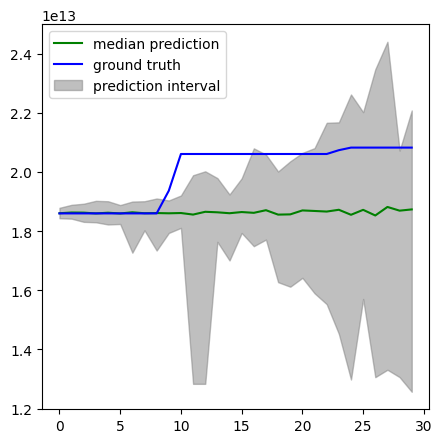

In [41]:
# plot

x = np.arange(0, len(median_prediction))

fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(x, median_prediction, "g-", label="median prediction")
ax.plot(x, label["target"], "b-", label="ground truth")
ax.fill_between(
    x,
    inf_prediction,
    sup_prediction,
    color="gray",
    alpha=0.5,
    label="prediction interval",
)
ax.legend(loc="upper left")
plt.show()


<img src="img/rolling_eval.png" alt="Drawing" style="width: 800px;"/>

As shown in the above plot, we use GluonTS to construct rolling window evaluation

## Rolling forecast using predictions